## Testtask for ELMA
#### Author: Borisov Ivan

11.09.22

## Contents:
* [1.EDA](#eda)
* [2.Model](#model)
* [3.REST API](#api)
* [4.Improving the quality of determinining user's intent](#improvement)
* [5.ML Production](#prod)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"E:\Users\onlym\Downloads\dataset_intent_detection.csv", names=['classification','intent'])
df['intent'] = df['intent'].str.replace('-','')

# 1.EDA <a class="anchor" id="eda"></a>

In [3]:
#рассчитать долю классов
df.classification.value_counts(normalize=True).head(10)

Small_talk_food             0.062201
Another_joke                0.052632
Whoops                      0.050239
Smalltalk_answer            0.048325
Small_talk_boss             0.043541
Small_talk_fired            0.039713
Small_talk_you_are_right    0.038756
Sick_of_listeting           0.034450
Small_talk_creators         0.033493
Messing_up                  0.027751
Name: classification, dtype: float64

In [4]:
#Оценить длину фразы
df['WordCount'] = df['intent'].apply(lambda x: len(x.split()))

Очистим текст для частотного анализа, также сделаем сравнение с предобработанными данными и исходными

In [5]:
import nltk
from nltk.corpus import stopwords

In [6]:
print(nltk.corpus.stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [7]:
lst_stopwords = nltk.corpus.stopwords.words('russian')
new_stopwords = ['что','это','в','и','очень','просто','как','вас','почему']
lst_stopwords.extend(new_stopwords)
remove_words = ['больше','не','где', 'когда','все','нет','всегда','иногда','что','можно','как','куда']
for w in remove_words:
    lst_stopwords.remove(w)

In [8]:
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=True, lst_stopwords=None):
    ## Обработаем текст (преобразуем в нижний регистр и удалим знаки препинания и лишние символы)
    text = re.sub(r'[^\*\w\s]', '', str(text).lower().strip())
            
    ## Токенизируем (Преобразуем из строки в список)
    lst_text = text.split()
    ## Уберем стоп-слова
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Стемминг (уберем окончания)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Лемматизация (преобразуем слова в изначальную форму)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## вернемся к строке из списка
    text =' '.join(lst_text)
    return text

In [9]:
df['text_clean'] = df['intent'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

**Сделаем частотный анализ по каждому классу**

In [10]:
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk import FreqDist

In [11]:
def clean_text_data(text_data):
    word_list = []
    for val in text_data:
        text = str(val)
        text = text.lower()
        tokens = word_tokenize(text)
        words = [word for word in tokens if word.isalpha()]
        for w in words:
            word_list.append(w)
    return(word_list)

Тк в задании указано для каждого класса, то факторизируем названия классов и пройдемся циклом по каждому из них

In [12]:
df['classification_factorized'] = df['classification'].factorize(0)[0]

In [13]:
df[['classification','classification_factorized']]

,classification,classification_factorized
0,Positive-reaction,0
1,Positive-reaction,0
2,Positive-reaction,0
3,Positive-reaction,0
4,Positive-reaction,0
...,...,...
2085,smalltalk_greetings_nice_to_see_you,53
2086,smalltalk_greetings_nice_to_see_you,53
2087,smalltalk_greetings_nice_to_see_you,53
2088,smalltalk_greetings_nice_to_see_you,53


Частотный анализ по каждому классу, можно вывести любой из них

In [14]:
fdist = FreqDist(df.intent)

In [15]:
for i in range(54):
    fdist[i] = FreqDist(clean_text_data(df.text_clean[df.classification_factorized == i]))
    print(fdist[i].most_common(5))

[('бомба', 2), ('воу', 2), ('говорю', 1), ('вайвай', 1), ('вау', 1)]
[('не', 14), ('отсюда', 4), ('нравится', 2), ('умеешь', 2), ('искать', 2)]
[('утро', 6), ('бот', 5), ('вечера', 4), ('доброго', 4), ('желаю', 3)]
[('больше', 5), ('не', 5), ('все', 5), ('давай', 4), ('позже', 4)]
[('не', 14), ('ладно', 3), ('говори', 3), ('когда', 3), ('хочу', 3)]
[('ау', 2), ('нет', 1), ('работаешь', 1)]
[('твоя', 4), ('биография', 2), ('история', 2), ('семейная', 1), ('родословная', 1)]
[('бот', 9), ('не', 5), ('робот', 4), ('чат', 3), ('ботом', 3)]
[('имя', 12), ('тебе', 10), ('тобой', 9), ('твоего', 9), ('твой', 7)]
[('работы', 19), ('уволена', 14), ('больше', 11), ('не', 8), ('уволить', 8)]
[('еду', 2), ('го', 1), ('обед', 1), ('голодная', 1), ('заказать', 1)]
[('любишь', 7), ('тебе', 3), ('какую', 2), ('расскажи', 2), ('хобби', 2)]
[('ржу', 5), ('смешно', 4), ('не', 3), ('могу', 3), ('смеяться', 3)]
[('тебе', 4), ('учиться', 4), ('не', 3), ('обучать', 2), ('будь', 2)]
[('скучная', 11), ('такая',

In [16]:
#Пример вывода 1 класса Negative_reaction
fdist[1]

FreqDist({'не': 14, 'отсюда': 4, 'нравится': 2, 'умеешь': 2, 'искать': 2, 'бред': 1, 'согласна': 1, 'согласен': 1, 'протестую': 1, 'вали': 1, ...})

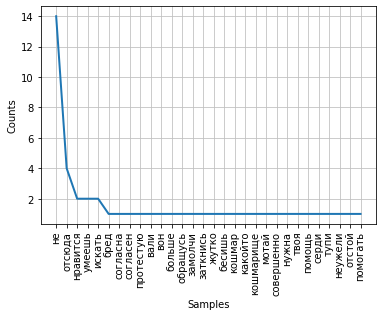

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
fdist[1].plot(30,cumulative=False)

Пример wordcloud на очищенных данных

In [18]:
from wordcloud import WordCloud

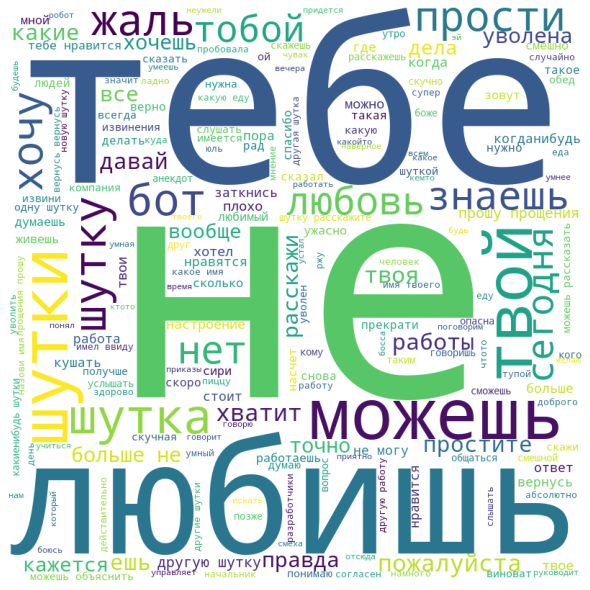

In [19]:
comment_words = ''
# iterate through the csv file
for val in df.text_clean:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# 2.Model <a class="anchor" id="model"></a>

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import numpy as np

In [21]:
X = df.text_clean
y = df.classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [22]:
%%time
pipe_logreg = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', LogisticRegression()),
])
parameters = [{
    'vect__max_features':[None, 5000, 10000, 50000],
     'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'clf__penalty': ('l1','l2', 'elasticnet',None),
    'clf__C': (100, 10, 1.0, 0.1, 0.01)
}]

grid_search = GridSearchCV(pipe_logreg, parameters)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__C': 10, 'clf__penalty': 'l2', 'vect__max_features': None, 'vect__ngram_range': (1, 1)}
0.5448780051836625
Wall time: 5min 5s


In [23]:
%%time
pipe_log = Pipeline([
           ('vect', TfidfVectorizer(max_features=50000,ngram_range=(1,2))),
           ('clf', LogisticRegression(C=10,penalty='l2',random_state=42)),
])
pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)
predicted_prob = pipe_log.predict_proba(X_test)

print('accuracy %s',  accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy %s 0.5526315789473685
                                     precision    recall  f1-score   support

                       Another_joke       0.67      1.00      0.80        20
                           Bad_joke       0.60      0.43      0.50         7
                         Compliment       0.00      0.00      0.00         6
                    Dont_understand       0.33      0.33      0.33         3
                             Finish       0.75      0.33      0.46         9
                              Hello       1.00      0.09      0.17        11
                         I_can_help       1.00      0.67      0.80         3
                         Messing_up       0.50      0.40      0.44        10
                               Name       0.60      0.60      0.60         5
                  Negative_reaction       0.36      0.67      0.47         6
                  Positive-reaction       0.00      0.00      0.00         4
                  Sick_of_listeting       0.

In [38]:
%%time
pipe_sgd = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SGDClassifier()),
])
parameters = [{
    'vect__max_features':[None, 5000, 10000, 50000],
     'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'clf__alpha': (0.0001, 0.001, 0.01, 0.1),
    'clf__loss': ('hinge', 'log', 'squared_hinge', 'modified_huber'),
    'clf__penalty': ('l1','l2', 'elasticnet',None),
    'clf__max_iter': (10, 50, 100)
}]

grid_search = GridSearchCV(pipe_sgd, parameters)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__alpha': 0.001, 'clf__loss': 'squared_hinge', 'clf__max_iter': 50, 'clf__penalty': 'l2', 'vect__max_features': 5000, 'vect__ngram_range': (1, 1)}
0.5514612565912951
Wall time: 14min 14s


In [37]:
%%time
pipe_sgd = Pipeline([
           ('vect', TfidfVectorizer(max_features=5000,ngram_range=(1,2))),
           ('clf', SGDClassifier(loss='modified_huber')),
])
pipe_sgd.fit(X_train, y_train)
y_pred = pipe_sgd.predict(X_test)
predicted_prob = pipe_sgd.predict_proba(X_test)

print('accuracy %s',  accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy %s 0.5502392344497608
                                     precision    recall  f1-score   support

                       Another_joke       0.65      1.00      0.78        20
                           Bad_joke       0.50      0.43      0.46         7
                         Compliment       0.25      0.17      0.20         6
                    Dont_understand       0.50      0.67      0.57         3
                             Finish       0.67      0.22      0.33         9
                              Hello       1.00      0.09      0.17        11
                         I_can_help       1.00      0.67      0.80         3
                         Messing_up       0.57      0.40      0.47        10
                               Name       0.75      0.60      0.67         5
                  Negative_reaction       0.40      0.33      0.36         6
                  Positive-reaction       0.00      0.00      0.00         4
                  Sick_of_listeting       0.

In [39]:
%%time
pipe_cat = Pipeline([
           ('vect', TfidfVectorizer(max_features=5000,ngram_range=(1,2))),
           ('clf', CatBoostClassifier()),
])
pipe_cat.fit(X_train, y_train)
y_pred = pipe_cat.predict(X_test)
predicted_prob = pipe_cat.predict_proba(X_test)

print('accuracy %s',  accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.081228
0:	learn: 3.9295088	total: 169ms	remaining: 2m 48s
1:	learn: 3.8767296	total: 341ms	remaining: 2m 49s
2:	learn: 3.8378746	total: 497ms	remaining: 2m 45s
3:	learn: 3.8077330	total: 657ms	remaining: 2m 43s
4:	learn: 3.7785945	total: 814ms	remaining: 2m 42s
5:	learn: 3.7539694	total: 973ms	remaining: 2m 41s
6:	learn: 3.7320720	total: 1.13s	remaining: 2m 40s
7:	learn: 3.7137438	total: 1.29s	remaining: 2m 40s
8:	learn: 3.6981532	total: 1.46s	remaining: 2m 40s
9:	learn: 3.6790445	total: 1.62s	remaining: 2m 40s
10:	learn: 3.6653404	total: 1.78s	remaining: 2m 40s
11:	learn: 3.6560305	total: 1.94s	remaining: 2m 39s
12:	learn: 3.6447822	total: 2.1s	remaining: 2m 39s
13:	learn: 3.6374691	total: 2.27s	remaining: 2m 39s
14:	learn: 3.6274525	total: 2.42s	remaining: 2m 39s
15:	learn: 3.6141205	total: 2.58s	remaining: 2m 38s
16:	learn: 3.6059617	total: 2.74s	remaining: 2m 38s
17:	learn: 3.5960163	total: 2.9s	remaining: 2m 38s
18:	learn: 3.5878761	total: 3.08s	remaining: 2

158:	learn: 3.1030058	total: 27.9s	remaining: 2m 27s
159:	learn: 3.1008174	total: 28.1s	remaining: 2m 27s
160:	learn: 3.0990218	total: 28.3s	remaining: 2m 27s
161:	learn: 3.0967198	total: 28.4s	remaining: 2m 27s
162:	learn: 3.0950408	total: 28.6s	remaining: 2m 27s
163:	learn: 3.0922912	total: 28.8s	remaining: 2m 26s
164:	learn: 3.0888134	total: 29s	remaining: 2m 26s
165:	learn: 3.0869757	total: 29.2s	remaining: 2m 26s
166:	learn: 3.0847189	total: 29.3s	remaining: 2m 26s
167:	learn: 3.0819759	total: 29.5s	remaining: 2m 26s
168:	learn: 3.0807303	total: 29.7s	remaining: 2m 25s
169:	learn: 3.0785515	total: 29.9s	remaining: 2m 25s
170:	learn: 3.0762603	total: 30s	remaining: 2m 25s
171:	learn: 3.0751737	total: 30.2s	remaining: 2m 25s
172:	learn: 3.0733721	total: 30.4s	remaining: 2m 25s
173:	learn: 3.0707020	total: 30.6s	remaining: 2m 25s
174:	learn: 3.0690212	total: 30.8s	remaining: 2m 25s
175:	learn: 3.0677259	total: 31s	remaining: 2m 25s
176:	learn: 3.0653942	total: 31.2s	remaining: 2m 24s

314:	learn: 2.8762261	total: 56.8s	remaining: 2m 3s
315:	learn: 2.8755528	total: 57s	remaining: 2m 3s
316:	learn: 2.8741673	total: 57.2s	remaining: 2m 3s
317:	learn: 2.8730523	total: 57.3s	remaining: 2m 2s
318:	learn: 2.8716400	total: 57.5s	remaining: 2m 2s
319:	learn: 2.8705093	total: 57.7s	remaining: 2m 2s
320:	learn: 2.8694630	total: 57.9s	remaining: 2m 2s
321:	learn: 2.8685986	total: 58.1s	remaining: 2m 2s
322:	learn: 2.8678780	total: 58.2s	remaining: 2m 2s
323:	learn: 2.8671836	total: 58.4s	remaining: 2m 1s
324:	learn: 2.8656195	total: 58.6s	remaining: 2m 1s
325:	learn: 2.8649905	total: 58.8s	remaining: 2m 1s
326:	learn: 2.8639512	total: 59s	remaining: 2m 1s
327:	learn: 2.8623226	total: 59.1s	remaining: 2m 1s
328:	learn: 2.8612880	total: 59.3s	remaining: 2m
329:	learn: 2.8603268	total: 59.5s	remaining: 2m
330:	learn: 2.8599375	total: 59.7s	remaining: 2m
331:	learn: 2.8593073	total: 59.9s	remaining: 2m
332:	learn: 2.8582064	total: 1m	remaining: 2m
333:	learn: 2.8572958	total: 1m	re

469:	learn: 2.7306529	total: 1m 25s	remaining: 1m 36s
470:	learn: 2.7299041	total: 1m 25s	remaining: 1m 35s
471:	learn: 2.7293834	total: 1m 25s	remaining: 1m 35s
472:	learn: 2.7280561	total: 1m 25s	remaining: 1m 35s
473:	learn: 2.7271790	total: 1m 25s	remaining: 1m 35s
474:	learn: 2.7266704	total: 1m 26s	remaining: 1m 35s
475:	learn: 2.7261345	total: 1m 26s	remaining: 1m 35s
476:	learn: 2.7253993	total: 1m 26s	remaining: 1m 34s
477:	learn: 2.7248394	total: 1m 26s	remaining: 1m 34s
478:	learn: 2.7238710	total: 1m 26s	remaining: 1m 34s
479:	learn: 2.7235399	total: 1m 27s	remaining: 1m 34s
480:	learn: 2.7225352	total: 1m 27s	remaining: 1m 34s
481:	learn: 2.7216575	total: 1m 27s	remaining: 1m 34s
482:	learn: 2.7210243	total: 1m 27s	remaining: 1m 33s
483:	learn: 2.7201306	total: 1m 27s	remaining: 1m 33s
484:	learn: 2.7195280	total: 1m 28s	remaining: 1m 33s
485:	learn: 2.7186005	total: 1m 28s	remaining: 1m 33s
486:	learn: 2.7179530	total: 1m 28s	remaining: 1m 33s
487:	learn: 2.7173443	total:

622:	learn: 2.6297266	total: 1m 53s	remaining: 1m 8s
623:	learn: 2.6291652	total: 1m 53s	remaining: 1m 8s
624:	learn: 2.6285004	total: 1m 54s	remaining: 1m 8s
625:	learn: 2.6277381	total: 1m 54s	remaining: 1m 8s
626:	learn: 2.6272380	total: 1m 54s	remaining: 1m 8s
627:	learn: 2.6263544	total: 1m 54s	remaining: 1m 7s
628:	learn: 2.6254975	total: 1m 54s	remaining: 1m 7s
629:	learn: 2.6248053	total: 1m 54s	remaining: 1m 7s
630:	learn: 2.6242490	total: 1m 55s	remaining: 1m 7s
631:	learn: 2.6238729	total: 1m 55s	remaining: 1m 7s
632:	learn: 2.6229977	total: 1m 55s	remaining: 1m 6s
633:	learn: 2.6226222	total: 1m 55s	remaining: 1m 6s
634:	learn: 2.6221541	total: 1m 55s	remaining: 1m 6s
635:	learn: 2.6218180	total: 1m 55s	remaining: 1m 6s
636:	learn: 2.6213196	total: 1m 56s	remaining: 1m 6s
637:	learn: 2.6208244	total: 1m 56s	remaining: 1m 5s
638:	learn: 2.6203242	total: 1m 56s	remaining: 1m 5s
639:	learn: 2.6197705	total: 1m 56s	remaining: 1m 5s
640:	learn: 2.6193447	total: 1m 56s	remaining:

780:	learn: 2.5407418	total: 2m 21s	remaining: 39.6s
781:	learn: 2.5402497	total: 2m 21s	remaining: 39.4s
782:	learn: 2.5396924	total: 2m 21s	remaining: 39.2s
783:	learn: 2.5392684	total: 2m 21s	remaining: 39.1s
784:	learn: 2.5386149	total: 2m 21s	remaining: 38.9s
785:	learn: 2.5382175	total: 2m 22s	remaining: 38.7s
786:	learn: 2.5379378	total: 2m 22s	remaining: 38.5s
787:	learn: 2.5377413	total: 2m 22s	remaining: 38.3s
788:	learn: 2.5372508	total: 2m 22s	remaining: 38.1s
789:	learn: 2.5368030	total: 2m 22s	remaining: 38s
790:	learn: 2.5363735	total: 2m 23s	remaining: 37.8s
791:	learn: 2.5358437	total: 2m 23s	remaining: 37.6s
792:	learn: 2.5354288	total: 2m 23s	remaining: 37.4s
793:	learn: 2.5348601	total: 2m 23s	remaining: 37.2s
794:	learn: 2.5343791	total: 2m 23s	remaining: 37.1s
795:	learn: 2.5340626	total: 2m 23s	remaining: 36.9s
796:	learn: 2.5336517	total: 2m 24s	remaining: 36.7s
797:	learn: 2.5330405	total: 2m 24s	remaining: 36.6s
798:	learn: 2.5326199	total: 2m 24s	remaining: 3

937:	learn: 2.4674505	total: 2m 49s	remaining: 11.2s
938:	learn: 2.4671463	total: 2m 49s	remaining: 11s
939:	learn: 2.4667990	total: 2m 50s	remaining: 10.9s
940:	learn: 2.4664801	total: 2m 50s	remaining: 10.7s
941:	learn: 2.4662807	total: 2m 50s	remaining: 10.5s
942:	learn: 2.4658244	total: 2m 50s	remaining: 10.3s
943:	learn: 2.4654408	total: 2m 50s	remaining: 10.1s
944:	learn: 2.4649985	total: 2m 50s	remaining: 9.95s
945:	learn: 2.4645758	total: 2m 51s	remaining: 9.77s
946:	learn: 2.4640334	total: 2m 51s	remaining: 9.59s
947:	learn: 2.4636849	total: 2m 51s	remaining: 9.41s
948:	learn: 2.4631454	total: 2m 51s	remaining: 9.23s
949:	learn: 2.4627422	total: 2m 51s	remaining: 9.05s
950:	learn: 2.4621582	total: 2m 52s	remaining: 8.87s
951:	learn: 2.4615612	total: 2m 52s	remaining: 8.69s
952:	learn: 2.4611282	total: 2m 52s	remaining: 8.51s
953:	learn: 2.4606130	total: 2m 52s	remaining: 8.32s
954:	learn: 2.4602008	total: 2m 52s	remaining: 8.14s
955:	learn: 2.4597957	total: 2m 53s	remaining: 7

In [26]:
import pickle

In [27]:
pickle_file_name = "pipe_test.pkl"  

with open(pickle_file_name, 'wb') as file:  
    pickle.dump(pipe_log, file)

In [28]:
input_data = ['Прекрасно']

In [29]:
with open(pickle_file_name, 'rb') as file:  
    pk_model = pickle.load(file)

In [30]:
y_predict = pk_model.predict_proba(input_data)
print(y_predict)

[[0.02660055 0.00478296 0.02198897 0.02745221 0.00775949 0.02110513
  0.02201769 0.01279071 0.02619374 0.00957432 0.01551803 0.02198337
  0.00682415 0.02822883 0.01456265 0.00882156 0.00945663 0.01916644
  0.03632647 0.00661457 0.01020555 0.03694051 0.02139619 0.00965487
  0.02908462 0.04044371 0.01102066 0.02797948 0.01239244 0.0045958
  0.00699275 0.01203374 0.00672685 0.01268573 0.00811353 0.03477619
  0.01486739 0.01057401 0.02099903 0.01998667 0.01345935 0.02148232
  0.01266107 0.04370978 0.0098736  0.07981275 0.02100815 0.00591539
  0.01580643 0.01357554 0.03600895 0.01817211 0.00575251 0.00352385]]


In [31]:
n = 3

probas = pk_model.predict_proba(input_data)
top_n_lables_idx = np.argsort(-probas, axis=1)[:, :n]
top_n_probs = np.round(-np.sort(-probas),3)[:, :n]
top_n_labels = [pk_model.classes_[i] for i in top_n_lables_idx]
    
results = list(zip(top_n_labels, top_n_probs))

In [32]:
predicted_intent = []
proba_intent = []

In [33]:
for i in range(3):
    predicted_intent.append(results[0][0][i])
    proba_intent.append(results[0][1][i])

In [34]:
predicted_intent

['Smalltalk_answer', 'Small_talk_you_are_right', 'Small_talk_food']

In [35]:
proba_intent

[0.08, 0.044, 0.04]

**Резюме**
1. @PR=0.66 @R=0.5 ACC=0.55
2. Подбор гиперпараметров занял около 5-7 минут
3. Wall time: 85 ms
4. Объем памяти равен объему обучающей выборки + незначительная нагрузка на работу алгоритма, в данном случае SGDClassifier + Tf-idf pipeline
5. Запустить профилирование модели
6. 1.53MB - pipe_log.pkl

# 3.REST API <a class="anchor" id="api"></a>

Готовый файл в app.py.  Деплой модели через docker в **Dockerfile, docker-compose.yml**

# 4.Improvement <a class="anchor" id="improvement"></a>

1. Для достижения лучших метрик сначала использовался метод оверсемплинга через SMOTE, подбирались гиперпараметры, а также пробовались ruBERT'ы, но не нашел необходимых предобученных эмбедингов для данного типа задач. 
2. Также пробовался onehotencoding для кодирования каждого комментария и подачи в модель. Еще пробовал метод one vs all, Тоже не помогло. => вся проблема в предобученных эмбедингах

# 5.ML Production <a class="anchor" id="eda"></a>

Готовый файл с деплоем модели в **ELMA-test-task app.py через Flask**